# Model Data

In [208]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
#sns.set_style('ticks')
%config InlineBackend.figure_format = 'retina'
from matplotlib.pyplot import figure
from IPython.display import Markdown as md
import math

Lets load our prepared data:

In [209]:
df = pd.read_pickle('nyc-2017-yellow-taxi-trips-to-airport-transformed.pkl.gz')

## Some more cleaning

In [210]:
df.isna().sum()

pickup_datetime          0
dropoff_datetime         0
trip_distance            0
pickup_borough           0
pickup_zone              0
dropoff_zone             0
pickup_service_zone      0
dropoff_month            0
drop_off_week_of_year    0
dropoff_day_of_year      0
dropoff_day_of_month     0
dropoff_weekday          0
dropoff_is_weekend       0
dropoff_hour             0
trip_duration_minutes    0
trip_duration_hours      0
trip_velocity            0
dtype: int64

No missing values.

Lets check our new variable for velocity.

In [211]:
df.trip_velocity.describe()

count    2.509468e+06
mean     4.795880e+01
std      6.616499e+02
min      0.000000e+00
25%      1.648739e+01
50%      2.206076e+01
75%      2.877454e+01
max      9.864000e+04
Name: trip_velocity, dtype: float64

Hoho ... maximum value of 98,000 miles per hours. Thats fast.

Lets see how many trips were faster than 70 miles per hours.

In [212]:
df[df.trip_velocity > 70].shape

(16095, 17)

How many is this in percent of all rows?

In [213]:
100*df[df.trip_velocity > 70].shape[0] / df.shape[0]

0.6413709997497478

Less than 1%, so lets drop them.

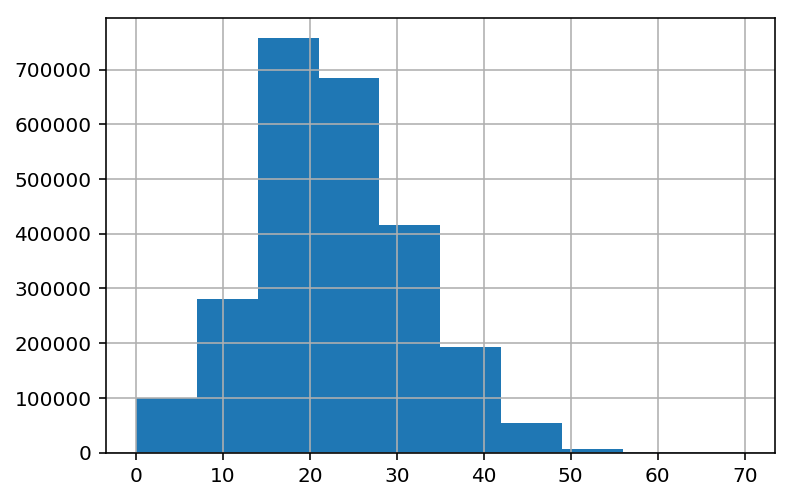

In [214]:
df = df[df.trip_velocity <= 70]
df.trip_velocity.hist()


In [215]:
def duration_hist(df, title, y_scale_log=False, cumulative=False):
    figure(figsize=(6,3))
    maxmins = int(df.trip_duration_minutes.max())
    step = 10**math.ceil(math.log10(maxmins/50))
    if maxmins/step < 10:
        step = int(step/2)
    df.trip_duration_minutes.hist(bins=range(0, maxmins, step),
                                  rwidth=.9, align='mid')
    if y_scale_log:
        plt.yscale('log')
    plt.xlabel('trip duration in minutes')
    plt.ylabel('count of trips')
    plt.xticks(range(0, maxmins, step), rotation=90);
    plt.title(("{:,} " + title).format(df.shape[0]))
    plt.savefig(title.replace(' ','_')+'.png', dpi=1200)

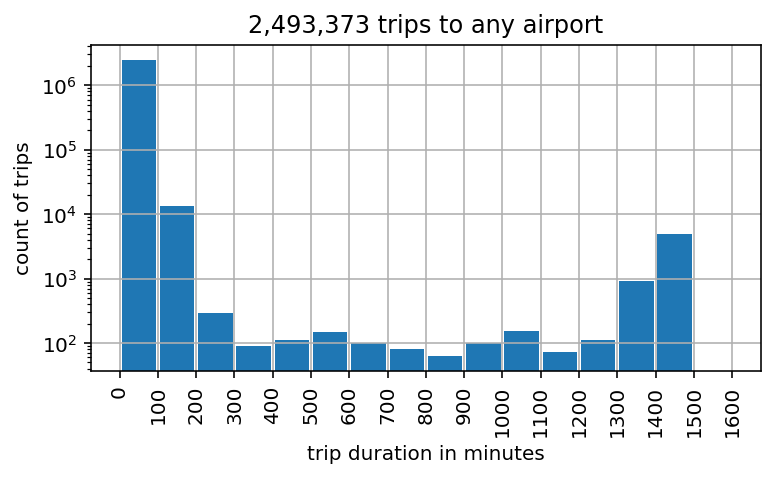

In [216]:
duration_hist(df, "trips to any airport", y_scale_log=1)

Thats strange, some trips took more than 10 hours? How many of them? 

In [217]:
(df.trip_duration_minutes > 600).sum(), (df.trip_duration_minutes > 600).mean()

(6532, 0.002619744418504572)

I decide to drop all that take longer than 10 hours, since there are not so many.

In [218]:
df = df[df.trip_duration_minutes <= 600]

# Question 1: Should we have planned more time for the transfer?

In [42]:
airports = df.dropoff_zone.unique().astype('str')

In [241]:
md(("## In 2017 there were {:,} Yellow Taxi trips to one of the three airports:\n"+
   "## * {}\n"+
   "## * {}\n"+
   "## * {}\n").format(df.shape[0], *airports))

## In 2017 there were 2,486,841 Yellow Taxi trips to one of the three airports:
## * JFK Airport
## * LaGuardia Airport
## * Newark Airport


In [240]:
df_ewr = df[df.dropoff_zone == 'Newark Airport']
df_mh_ewr = df_ewr[df_ewr.pickup_zone == 'Murray Hill']
df_mh_jfk = df[(df.pickup_zone == 'Murray Hill') & (df.dropoff_zone == 'JFK Airport')]
df_mh_lga = df[(df.pickup_zone == 'Murray Hill') & (df.dropoff_zone == 'LaGuardia Airport')]
df_mh_ewr_wd = df_mh_ewr[df_mh_ewr.dropoff_is_weekend == False]
df_mh_ewr_fr = df_mh_ewr[df_mh_ewr.dropoff_datetime.dt.day == 4]

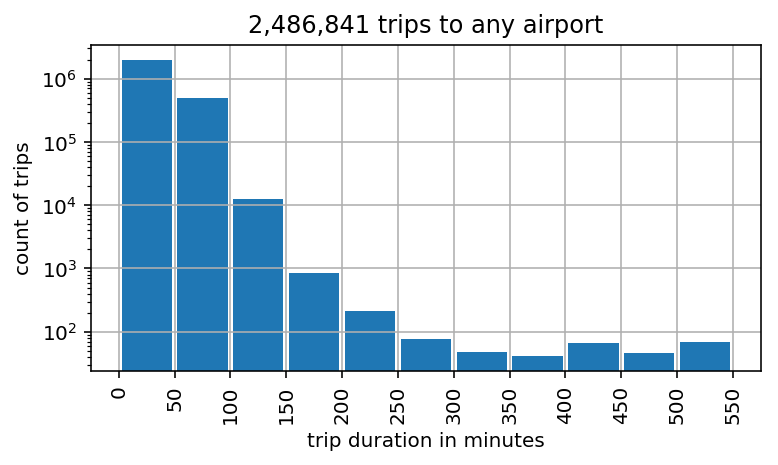

In [228]:
duration_hist(df, "trips to any airport", y_scale_log=1)

In [220]:
df.trip_duration_minutes.quantile(.99)

93.03333333333333

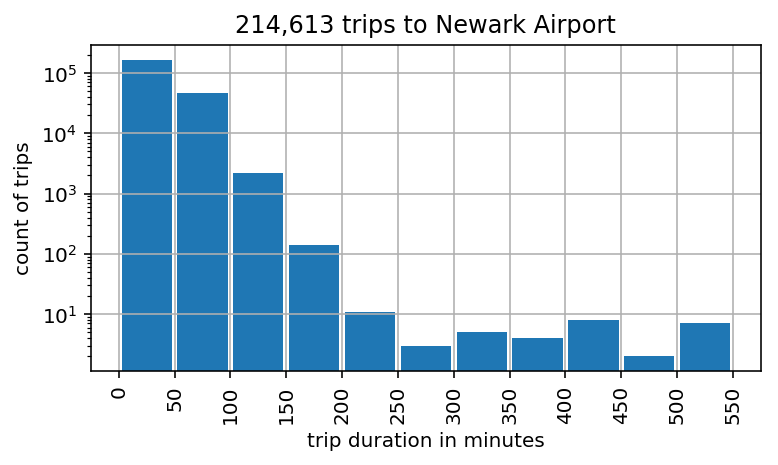

In [230]:
duration_hist(df_ewr, "trips to Newark Airport", y_scale_log=1)

In [231]:
df_ewr.trip_duration_minutes.quantile(.99)

101.66666666666667

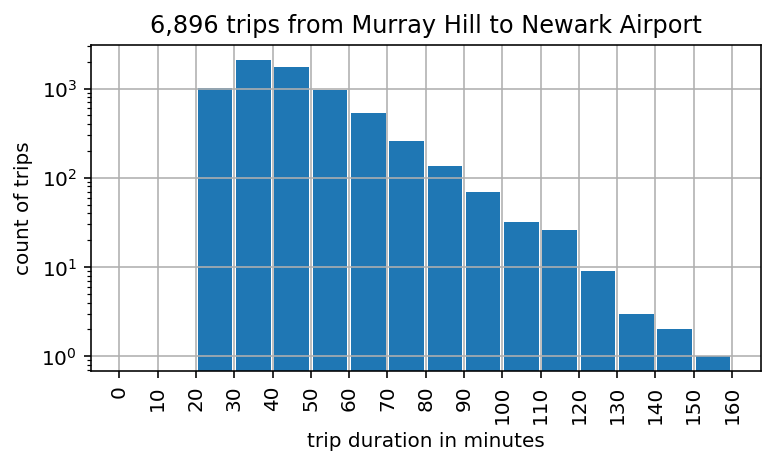

In [233]:
duration_hist(df_mh_ewr, "trips from Murray Hill to Newark Airport", y_scale_log=1)

In [224]:
df_mh_ewr.trip_duration_minutes.quantile(.99)

101.65833333333347

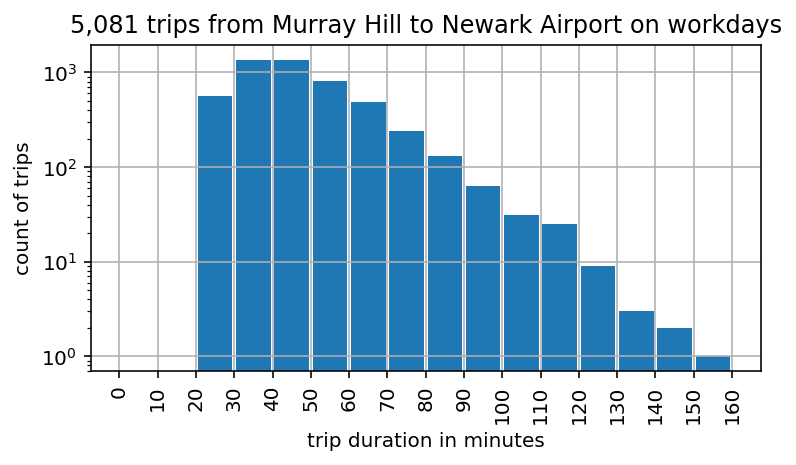

In [234]:
duration_hist(df_mh_ewr_wd, "trips from Murray Hill to Newark Airport on workdays", y_scale_log=1)

In [235]:
df_mh_ewr_wd.trip_duration_minutes.quantile(.99)

107.04333333333327

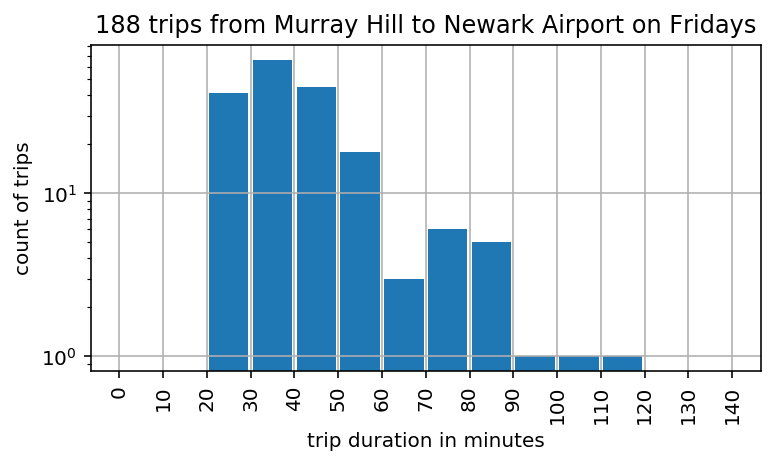

In [237]:
duration_hist(df_mh_ewr_fr, "trips from Murray Hill to Newark Airport on Fridays", y_scale_log=1)

In [110]:
df_mh_ewr_fr.trip_duration_minutes.quantile(.99)

108.56983333333328

In [111]:
df_mh_ewr_17 = df_mh_ewr[df_mh_ewr.dropoff_hour == 17]
df_ewr_17 = df_ewr[df_ewr.dropoff_hour == 17]
df_mh_ewr_fr_17 = df_mh_ewr_fr[df_mh_ewr_fr.dropoff_hour == 17]

In [112]:
df_mh_ewr_16 = df_mh_ewr[df_mh_ewr.dropoff_hour.isin([16,17])]
df_ewr_16 = df_ewr[df_ewr.dropoff_hour.isin([16,17])]
#df_mh_ewr_fr_16 = df_mh_ewr_fr[df_mh_ewr_fr.isin([16,17])]

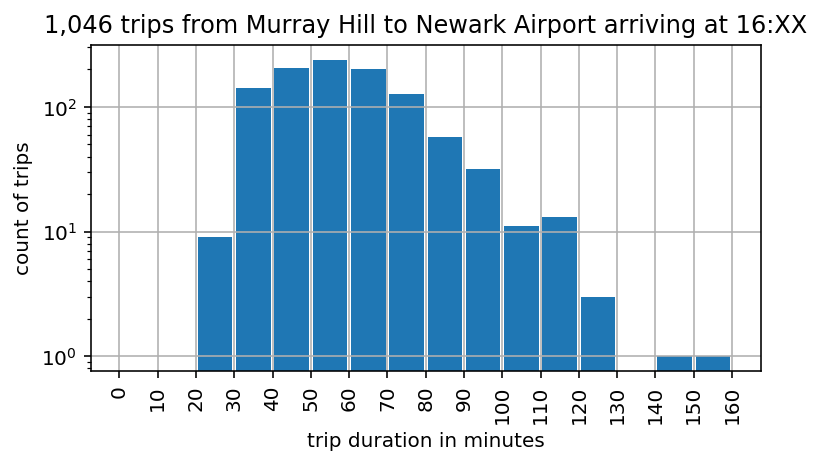

In [238]:
duration_hist(df_mh_ewr_16, "trips from Murray Hill to Newark Airport arriving at 16:XX", y_scale_log=1)

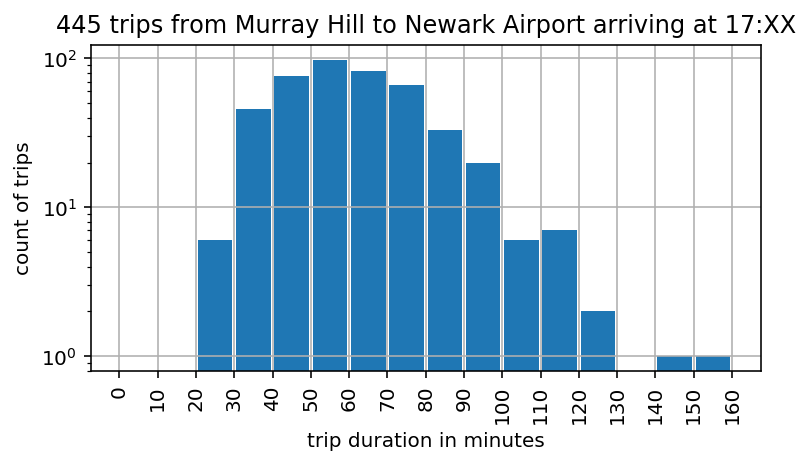

In [252]:
duration_hist(df_mh_ewr_17, "trips from Murray Hill to Newark Airport arriving at 17:XX", y_scale_log=1)

In [253]:
df_mh_ewr_17.trip_duration_minutes.quantile(.99)

123.73933333333336

## Question 2: Which of the three airports has best reachability from the quarter where we stayed this time? (Murray Hill)

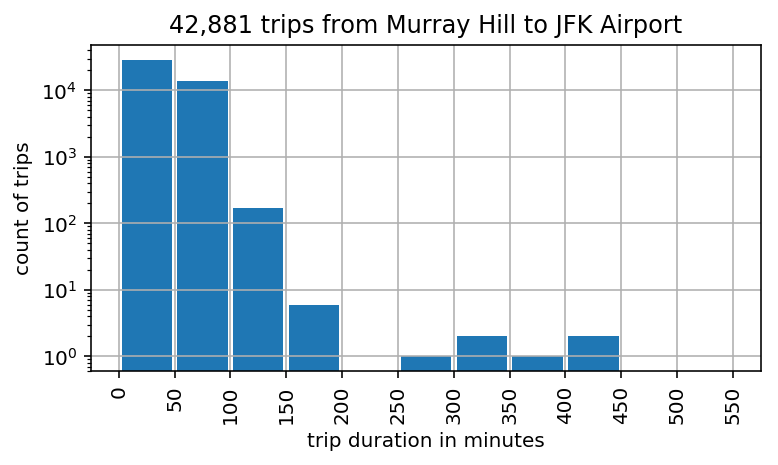

In [242]:
duration_hist(df_mh_jfk, "trips from Murray Hill to JFK Airport", y_scale_log=1)

In [243]:
df_mh_jfk.trip_duration_minutes.quantile(.99)

91.93666666666638

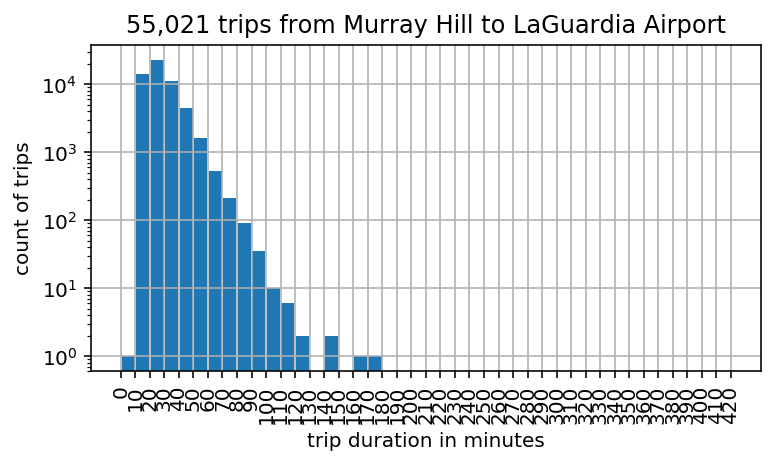

In [244]:
duration_hist(df_mh_lga, "trips from Murray Hill to LaGuardia Airport", y_scale_log=1)

In [245]:
df_mh_lga.trip_duration_minutes.quantile(.99)

64.90666666666682

In [246]:
df_mh_ewr.trip_duration_minutes.quantile(.99)

101.65833333333347

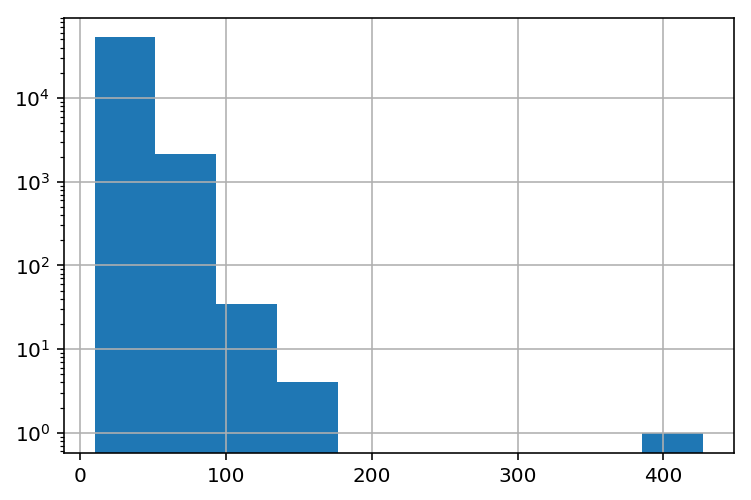

In [247]:
df_mh_lga.trip_duration_minutes.hist()
plt.yscale('log')

In [248]:
(df_mh_lga.trip_duration_minutes > 200).sum()

1

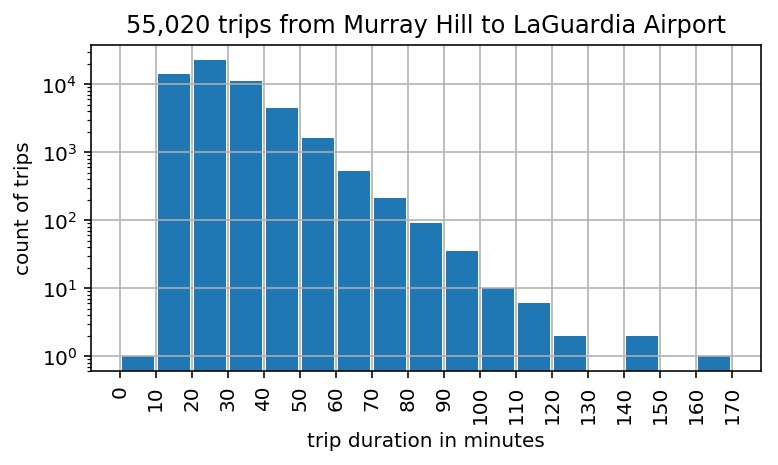

In [250]:
duration_hist(df_mh_lga[df_mh_lga.trip_duration_minutes <= 200], "trips from Murray Hill to LaGuardia Airport", y_scale_log=1)

## Question 3: Which zone in Manhattan has best reachability to Newark Airport

In [251]:
manhattan_zones = df[df.pickup_borough == 'Manhattan'].pickup_zone.unique()

In [154]:
df[df.pickup_zone == 'Clinton East'].trip_duration_minutes.quantile(.99)

98.01899999999975

In [192]:
def transfer_duration_quantile(zone, q):
    return df_ewr[df_ewr.pickup_zone == zone].trip_duration_minutes.quantile(q)
def transfer_distance_quantile(zone, q):
    return df_ewr[df_ewr.pickup_zone == zone].trip_distance.quantile(q)

In [193]:
transfer_duration_quantile('Greenwich Village North', .99)

100.32283333333326

In [196]:
ewr_xfer_time_99perc = pd.Series()
ewr_xfer_distance_99perc = pd.Series()
for z in manhattan_zones:
    ewr_xfer_time_99perc[z] = transfer_duration_quantile(z, .99)
    ewr_xfer_distance_99perc[z] = transfer_distance_quantile(z, .99)
ewr_xfer_time_99perc = ewr_xfer_time_99perc.sort_values()


In [186]:
ewr_xfer_time_99perc[:10]

Highbridge Park              52.943333
Inwood                       64.182667
Washington Heights South     64.396667
Manhattanville               69.159333
Washington Heights North     70.910000
Hudson Sq                    78.220000
West Chelsea/Hudson Yards    83.563667
Garment District             83.631333
Clinton East                 83.733333
Clinton West                 84.641667
dtype: float64

In [187]:
ewr_xfer_time_99perc[-10:]

Randalls Island                                  112.924167
Yorkville West                                   113.589500
Yorkville East                                   113.810667
East Harlem North                                117.877333
Two Bridges/Seward Park                          119.804000
Financial District South                         125.490333
Inwood Hill Park                                        NaN
Roosevelt Island                                        NaN
Marble Hill                                             NaN
Governor's Island/Ellis Island/Liberty Island           NaN
dtype: float64

In [201]:
df_ewr[df_ewr.pickup_zone.isin([
    'Marble Hill',
    'Inwood Hill Park',
    'Roosevelt Island',
    "Governor's Island/Ellis Island/Liberty Island"])]

,pickup_datetime,dropoff_datetime,trip_distance,pickup_borough,pickup_zone,dropoff_zone,pickup_service_zone,dropoff_month,drop_off_week_of_year,dropoff_day_of_year,dropoff_day_of_month,dropoff_weekday,dropoff_is_weekend,dropoff_hour,trip_duration_minutes,trip_duration_hours,trip_velocity


In [188]:
manhattan_zones.shape

(67,)

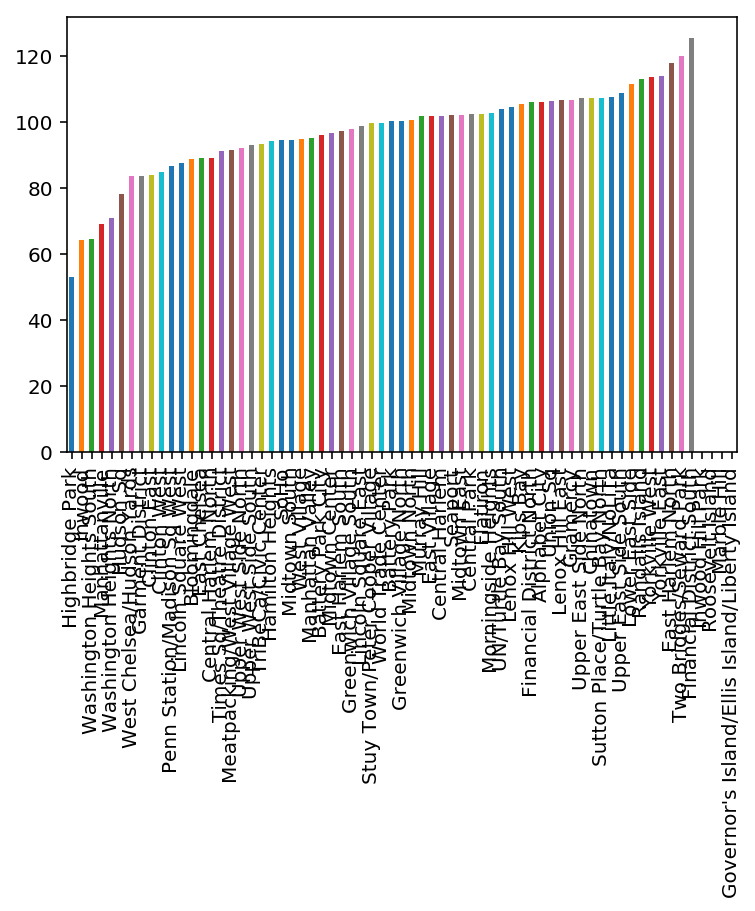

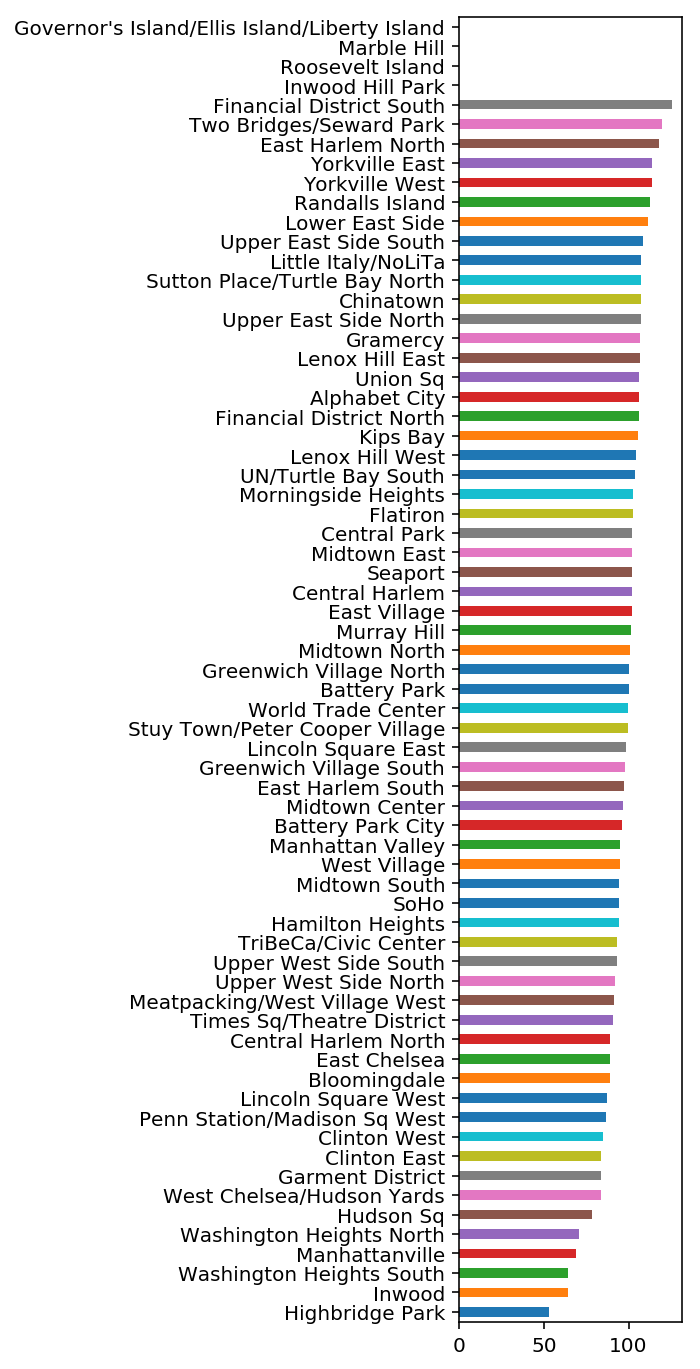

In [190]:
plt.figure(figsize=(2,12))
ewr_xfer_time_99perc.plot.barh()

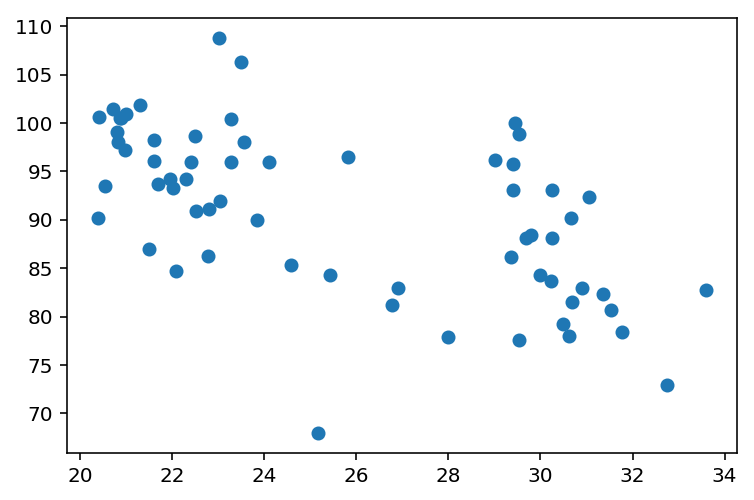

In [197]:
plt.scatter(x=ewr_xfer_distance_99perc, y=ewr_transfer_time_99perc)